# Spectral Embedding - Fashion MNIST

%Link al Colab: https://colab.research.google.com/drive/1h7E3Q-W3aCh-lo6yLyWqF7Es7Lgd_3Kn#scrollTo=DFtcMI4umT7t

## Importaciones

In [1]:
import pandas as pd
import matplotlib
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gdown
import numpy as np
import struct
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.manifold import SpectralEmbedding
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors

## Clase SpectralEmbeddingTransformer

In [2]:
class SpectralEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        n_components=2,
        n_neighbors=5,
        affinity="nearest_neighbors",
        gamma=None,
        random_state=42,
    ):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.affinity = affinity
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None):
        se = SpectralEmbedding(
            n_components=self.n_components,
            affinity=self.affinity,
            n_neighbors=self.n_neighbors,
            gamma=self.gamma,
            random_state=self.random_state,
            eigen_solver="arpack",
            n_jobs=-1,
        )

        self.embedding_ = se.fit_transform(X)
        self.X_train_ = X

        self.knn_ = NearestNeighbors(
            n_neighbors=min(self.n_neighbors, X.shape[0] - 1),
            algorithm="auto",
            n_jobs=-1,
        )
        self.knn_.fit(X)

        return self

    def transform(self, X):
        distances, indices = self.knn_.kneighbors(X)
        distances = distances + 1e-10

        weights = 1.0 / distances
        weights /= weights.sum(axis=1, keepdims=True)

        X_transformed = np.zeros((X.shape[0], self.n_components))
        for i, neighbor_indices in enumerate(indices):
            X_transformed[i] = np.average(
                self.embedding_[neighbor_indices], axis=0, weights=weights[i]
            )

        return X_transformed

## Funciones de Carga de Datos

In [3]:
def download_data(file_id, name_file):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, name_file, quiet=False)
    return name_file


def read_labels(file_path):
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot",
    }

    with open(file_path, "rb") as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    df = pd.DataFrame(labels, columns=["label"])
    df["class_name"] = df["label"].map(class_names)
    return df


def extrar_feature_images(file_path):
    with open(file_path, "rb") as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        print("Número de imágenes:", num_images)
        print("Dimensiones de cada imagen:", rows, "x", cols)
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        images = image_data.reshape(num_images, rows, cols)
        X = images.reshape(num_images, rows * cols)
        print("Forma de la matriz final:", X.shape)
    return X

## Funciones de Visualización

In [4]:
def Show_Image(X, nro_imagen):
    img = X[nro_imagen].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Imagen #{nro_imagen}")
    plt.axis("off")
    plt.show()


def visualizar_reduccion_2d(X_reduced, y, metodo_nombre, class_names_dict):
    plt.figure(figsize=(12, 10))

    for clase in np.unique(y):
        indices = y == clase
        plt.scatter(
            X_reduced[indices, 0],
            X_reduced[indices, 1],
            label=class_names_dict[clase],
            alpha=0.6,
            s=20,
        )

    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.title(f"Visualización 2D - {metodo_nombre}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

## Funciones de Preprocesamiento

In [5]:
def normalize_train(x):
    scaler = MinMaxScaler()
    x_norm = scaler.fit_transform(x)
    return x_norm, scaler


def normalize_test(x, scaler):
    x_norm = scaler.transform(x)
    return x_norm


def addBias(x):
    return np.column_stack([np.ones(x.shape[0]), x])

## Funciones de Evaluación

In [13]:
def generar_matriz_confusion(
    y_true, y_pred, modelo_nombre, class_names=None
):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", values_format=".2f")
    plt.title(f"Matriz de Confusión - {modelo_nombre}")
    plt.tight_layout()
    plt.show()

    return cm


def evaluar_modelos(
    X_train, y_train, X_test, y_test, mostrar_matrices=True, save_dir="resultados"
):
    modelos = {
        "SVM": SVC(kernel="rbf", class_weight="balanced", random_state=42),
        "Logistic Regression": LogisticRegression(
            max_iter=2000, solver="saga", class_weight="balanced", random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=200, class_weight="balanced", random_state=42
        ),
        "KNN": KNeighborsClassifier(n_neighbors=5),
    }

    class_names = [
        "T-shirt",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]

    if mostrar_matrices:
        os.makedirs(save_dir, exist_ok=True)

    resultados = []

    for nombre, modelo in modelos.items():
        print(f"\nEntrenando {nombre}...")
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        resultados.append(
            {
                "Modelo": nombre,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
                "Recall": recall_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
                "F1-Score": f1_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
            }
        )

        if mostrar_matrices:
            generar_matriz_confusion(y_test, y_pred, nombre, class_names)

    return pd.DataFrame(resultados)

## Cargar Datos

In [7]:
# Descargando la data solo la primera vez
file_train_X = download_data("1enziBIpqiv_t95KQcifsclNH2BdR8lAd","train_X")
file_test_X = download_data("1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4","test_X")
file_train_Y = download_data("1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7","train_Y")
file_test_Y = download_data("1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4","test_Y")

Downloading...
From: https://drive.google.com/uc?id=1enziBIpqiv_t95KQcifsclNH2BdR8lAd
To: /content/train_X
100%|██████████| 47.0M/47.0M [00:00<00:00, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4
To: /content/test_X
100%|██████████| 7.84M/7.84M [00:00<00:00, 66.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7
To: /content/train_Y
100%|██████████| 60.0k/60.0k [00:00<00:00, 58.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4
To: /content/test_Y
100%|██████████| 10.0k/10.0k [00:00<00:00, 26.7MB/s]


## Preprocesamiento

In [8]:
train_X = extrar_feature_images(file_train_X )
test_X = extrar_feature_images(file_test_X )
train_Y = read_labels(file_train_Y)
test_Y = read_labels(file_test_Y)

train_X_norm, scaler = normalize_train(train_X)
test_X_norm = normalize_test(test_X, scaler)
train_X_norm = addBias(train_X_norm)
test_X_norm = addBias(test_X_norm)

Número de imágenes: 60000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (60000, 784)
Número de imágenes: 10000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (10000, 784)


## Spectral Embedding 2D

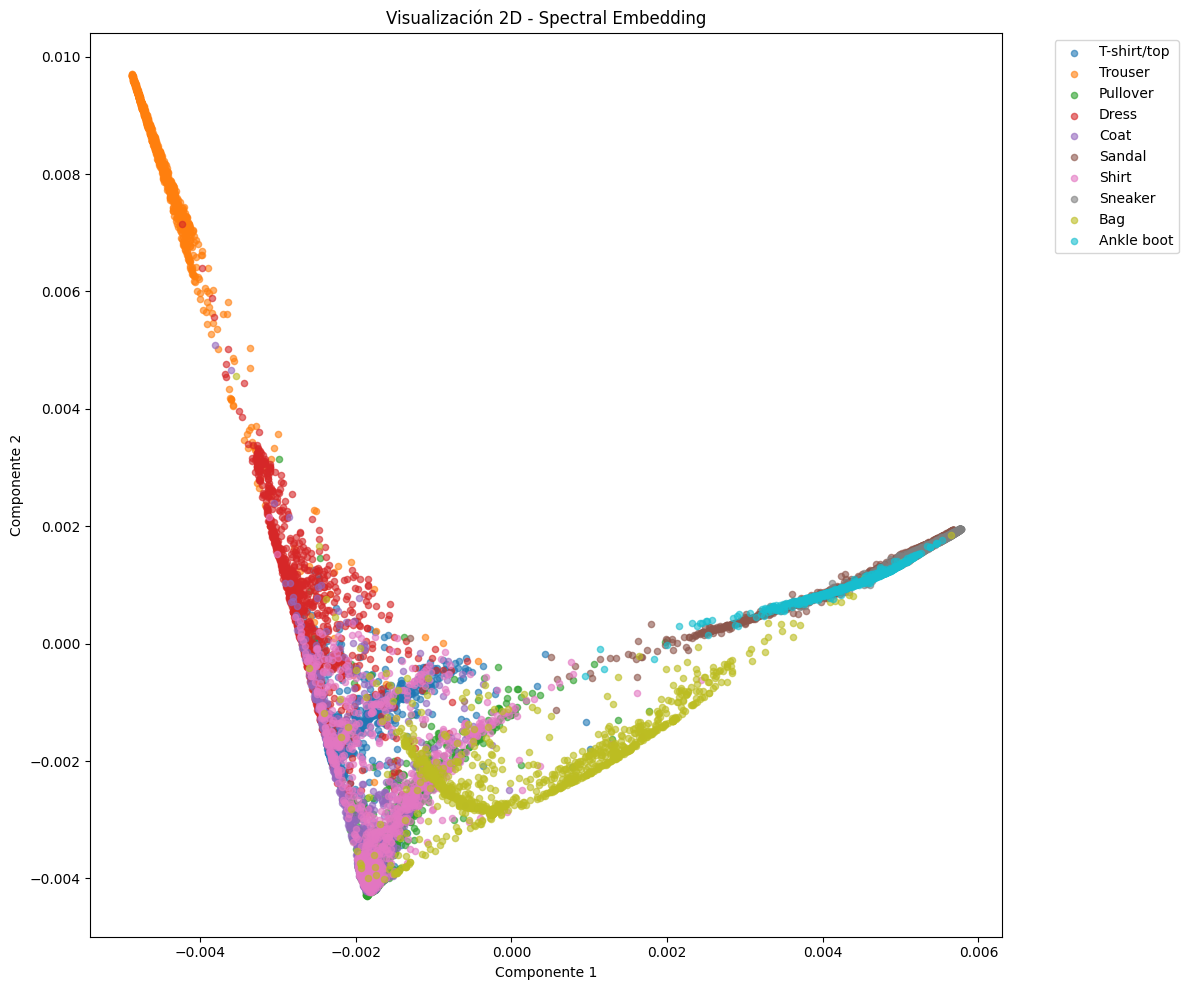

In [9]:
class_names_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

n_viz = min(10000, len(train_X_norm))
viz_indices = np.random.choice(len(train_X_norm), n_viz, replace=False)
X_viz = train_X_norm[viz_indices]
y_viz = train_Y["label"].values[viz_indices]

se_2d = SpectralEmbeddingTransformer(
    n_components=2, n_neighbors=10, affinity="nearest_neighbors", random_state=42
)
X_spectral_2d = se_2d.fit_transform(X_viz)

visualizar_reduccion_2d(
    X_spectral_2d,
    y_viz,
    "Spectral Embedding",
    class_names_dict,
)

## Implementacion de Spectral Embedding

In [10]:
n_components_clf = 250
n_train_samples = min(60000, len(train_X_norm))

train_indices = np.random.choice(len(train_X_norm), n_train_samples, replace=False)
X_train_sample = train_X_norm[train_indices]

se_clf = SpectralEmbeddingTransformer(
    n_components=n_components_clf,
    n_neighbors=15,
    affinity="nearest_neighbors",
    random_state=42,
)

train_X_spectral_sample = se_clf.fit_transform(X_train_sample)

## Transformar Todos los Datos

In [11]:
train_X_spectral = se_clf.transform(train_X_norm)
test_X_spectral = se_clf.transform(test_X_norm)

## Entrenamiento y Evaluación de Modelos


Entrenando SVM...


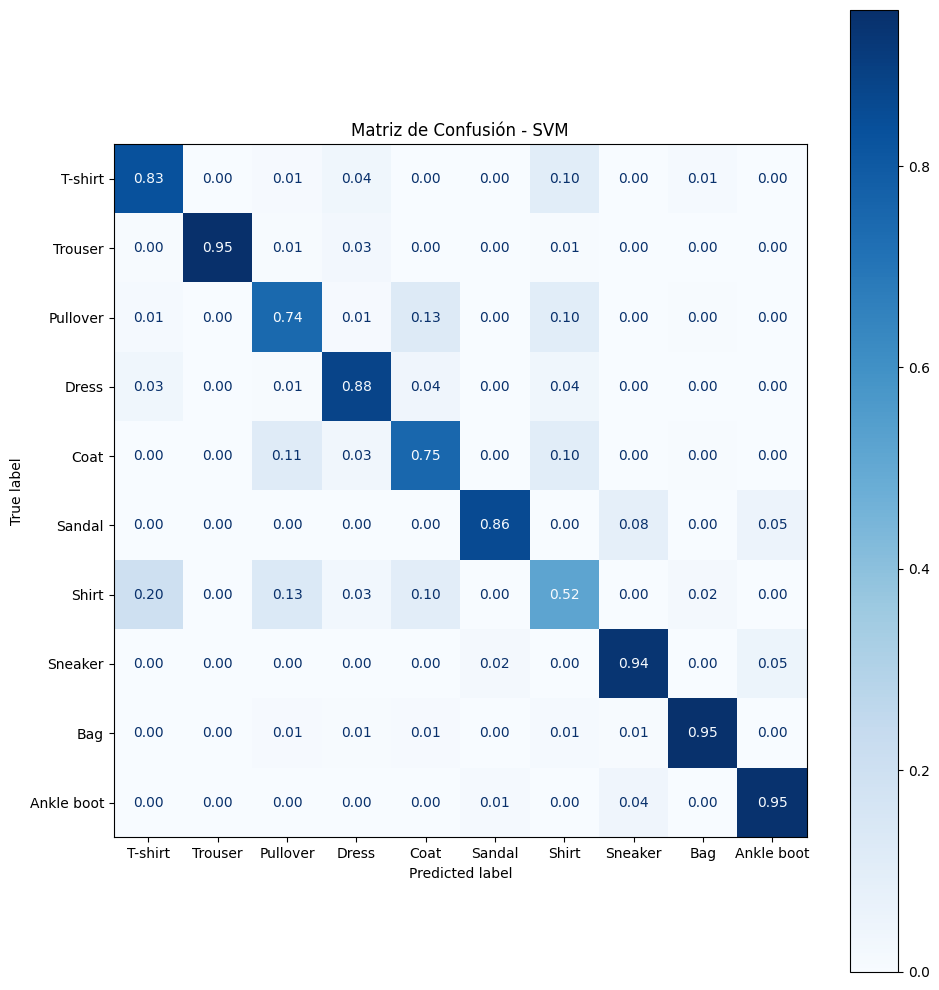


Entrenando Logistic Regression...


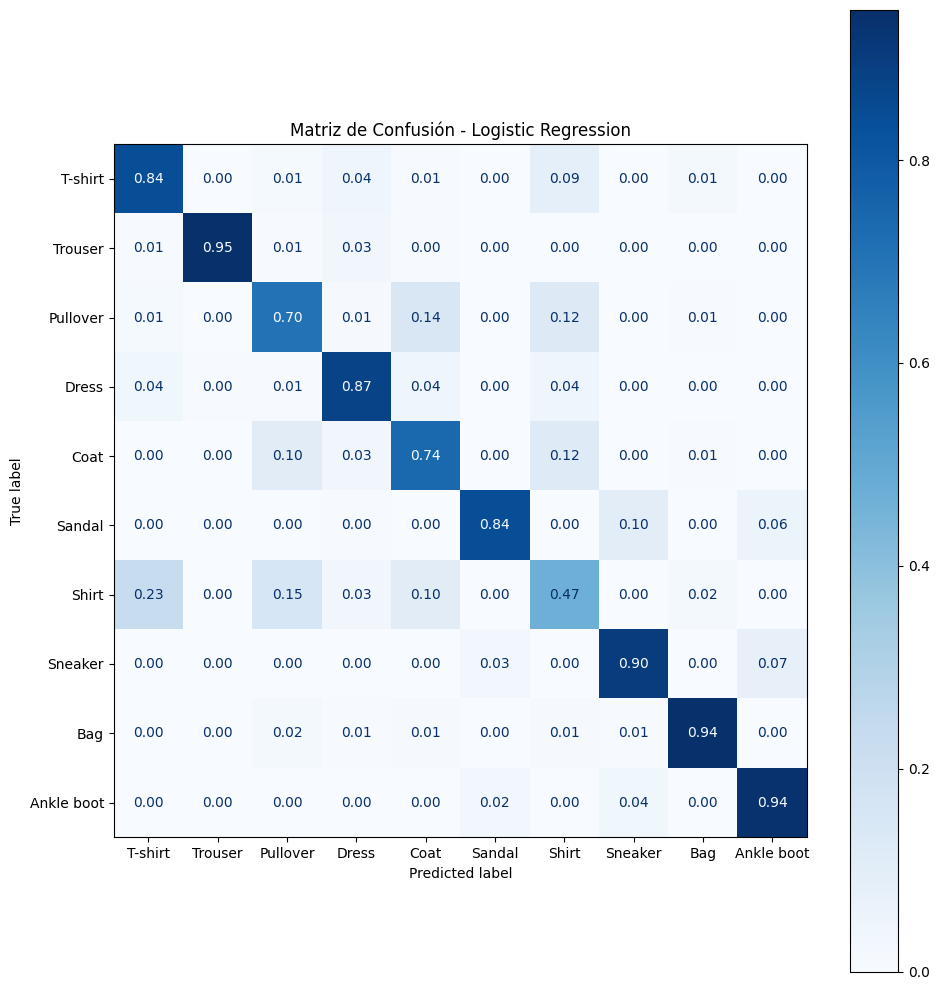


Entrenando Random Forest...


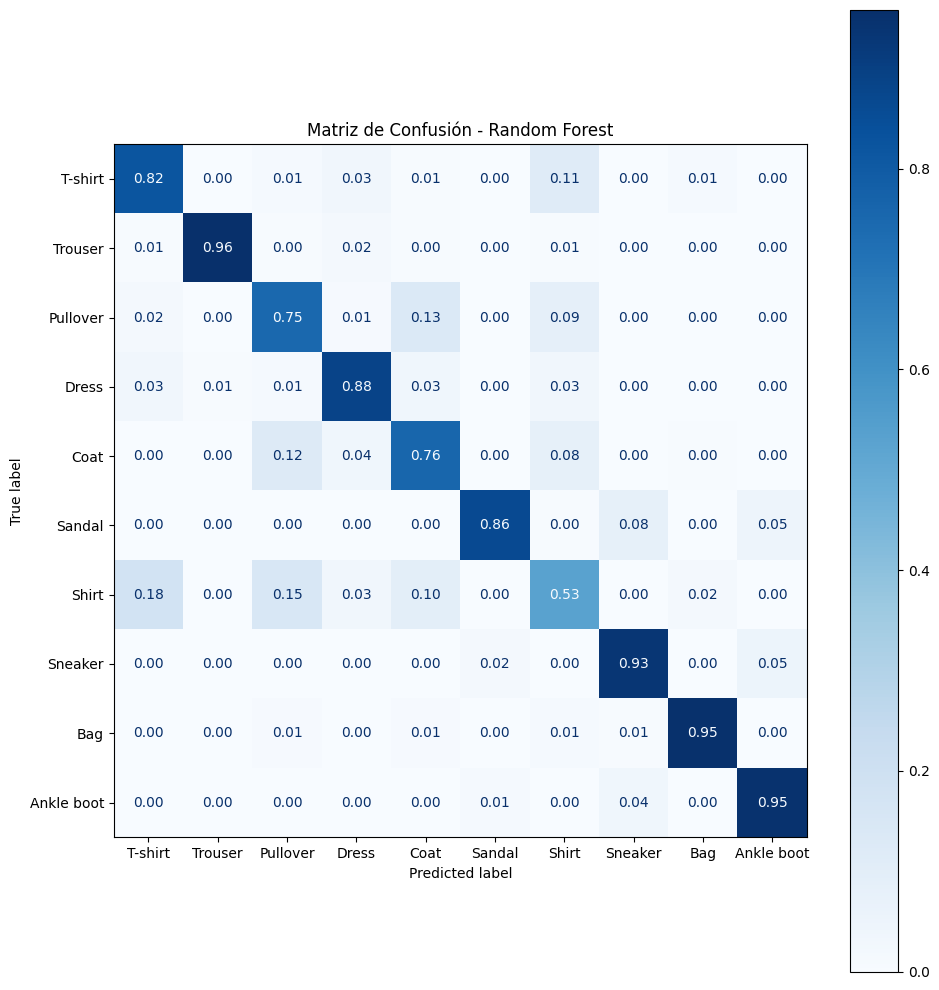


Entrenando KNN...


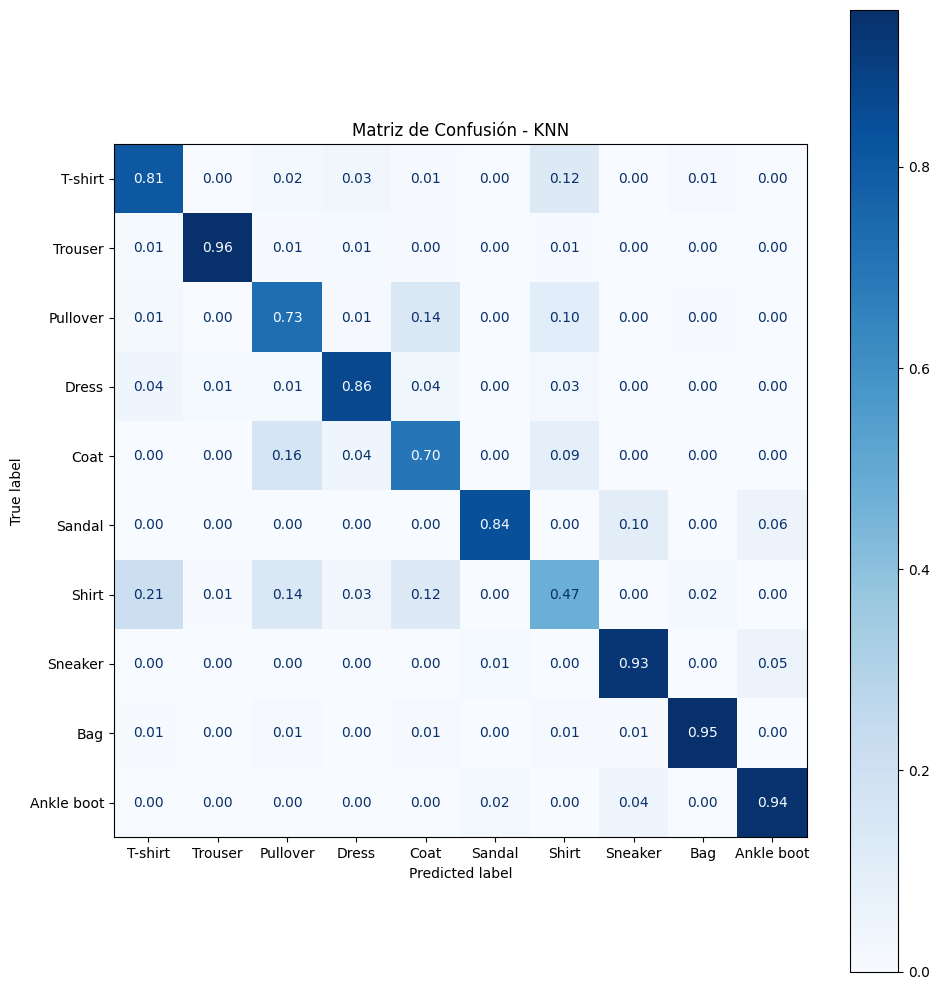

             Modelo  Accuracy  Precision  Recall  F1-Score
                SVM    0.8369   0.836784  0.8369  0.835944
Logistic Regression    0.8188   0.817705  0.8188  0.817087
      Random Forest    0.8401   0.839889  0.8401  0.839102
                KNN    0.8197   0.819452  0.8197  0.818262


In [14]:
resultados_spectral = evaluar_modelos(
    train_X_spectral,
    train_Y["label"].values,
    test_X_spectral,
    test_Y["label"].values,
    mostrar_matrices=True,
    save_dir="resultados_spectral",
)

print(resultados_spectral.to_string(index=False))